Data Cleaning and Preprocessing

In [8]:
import pandas as pd
# Load the dataset
data = pd.read_csv('Lloyds_data_real.csv')
# Summary statistics
print(data.describe())
# Check for missing values
print(data.isnull().sum())

          Unnamed: 0  individual_id    hour_of_day          spend
count  105277.000000  105277.000000  105277.000000  105277.000000
mean    52638.000000    1106.065712      13.033767      10.664062
std     30390.996482     623.544396       3.112180      18.435154
min         0.000000       1.000000       0.038128       0.000000
25%     26319.000000     579.000000      11.256765       2.200000
50%     52638.000000    1104.000000      13.027889       5.030000
75%     78957.000000    1644.000000      14.820689       9.980000
max    105276.000000    2185.000000      23.983769     180.830000
Unnamed: 0       0
individual_id    0
timestamp        0
date             0
day_of_week      0
hour_of_day      0
department       0
spend            0
dtype: int64


In [9]:
# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
# Extract hours and minutes from 'hour_of_day'
data['hour'] = data['hour_of_day'].astype(int)
data['minute'] = ((data['hour_of_day'] - data['hour']) * 60).astype(int)
# Convert 'timestamp' to total seconds
data['timestamp_seconds'] = data['timestamp'].apply(lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]))

In [10]:
# Extract additional time-based features from the 'date' and 'timestamp'
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['is_office_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x < 18 else 0)

In [11]:
# Generate rolling averages, rolling sums, and lagged features for 'spend'
data['rolling_spend_mean'] = data.groupby('individual_id')['spend'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
data['rolling_spend_sum'] = data.groupby('individual_id')['spend'].transform(lambda x: x.rolling(window=3, min_periods=1).sum())

In [12]:
# Calculate the time difference between consecutive transactions for each individual
data['time_diff'] = data.groupby('individual_id')['timestamp_seconds'].diff().fillna(0)
# Check if the transaction is the first transaction of the day
data['is_first_transaction'] = data.groupby(['individual_id', 'date'])['timestamp_seconds'].rank(method='first').apply(lambda x: 1 if x == 1 else 0)

In [13]:
# Calculate the transaction frequency in the last 7 days
data['transactions_last_7_days'] = data.groupby('individual_id')['date'].transform(lambda x: x.rolling(window=7, min_periods=1).count())
# Calculate the transaction frequency deviation from the mean
data['transactions_freq_deviation'] = data['transactions_last_7_days'] - data.groupby('individual_id')['transactions_last_7_days'].transform('mean')

In [14]:
# Calculate the ratio of the spend to the average spend of that individual
data['spend_to_mean_ratio'] = data['spend'] / data.groupby('individual_id')['spend'].transform('mean')
# Calculate the spend deviation from the rolling mean
data['spend_deviation'] = data['spend'] - data['rolling_spend_mean']

In [15]:
# Cumulative spend per individual
data['cumulative_spend'] = data.groupby('individual_id')['spend'].cumsum()
# Difference in spend from previous transaction
data['spend_diff'] = data.groupby('individual_id')['spend'].diff().fillna(0)

In [16]:
from scipy import stats
# Identify outliers in 'spend'
z_scores = stats.zscore(data['spend'])
outliers = data[(z_scores > 3) | (z_scores < -3)]
# Cap outliers
data['spend'] = data['spend'].apply(lambda x: x if x < outliers['spend'].min() else outliers['spend'].min())
# Display summary statistics to verify outlier treatment
print(data['spend'].describe())

count    105277.000000
mean          9.835594
std          14.763184
min           0.000000
25%           2.200000
50%           5.030000
75%           9.980000
max          65.970000
Name: spend, dtype: float64


In [17]:
# Mean spend per department
mean_spend_department = data.groupby('department')['spend'].mean().to_dict()
data['mean_spend_department'] = data['department'].map(mean_spend_department)

In [18]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

df_test = pd.read_csv("Lloyds_data.csv")
# True labels are in the column 'at_risk_event'
y_true = df_test['at_risk_event']

Data Visualization

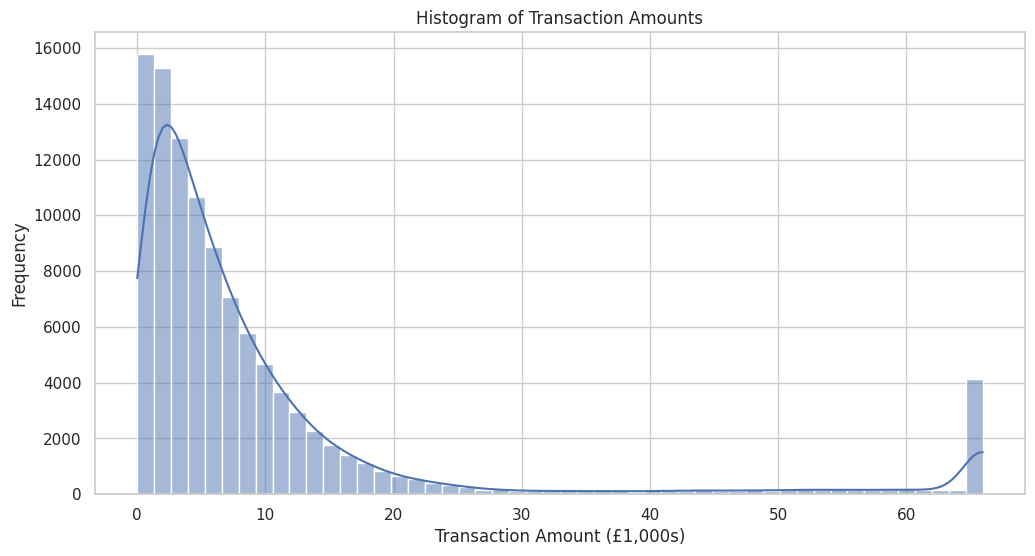

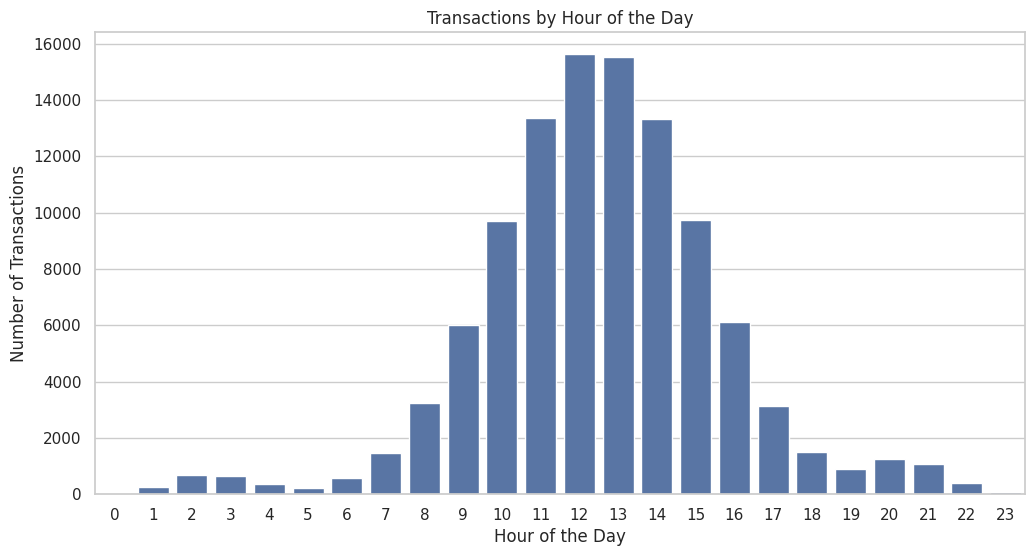

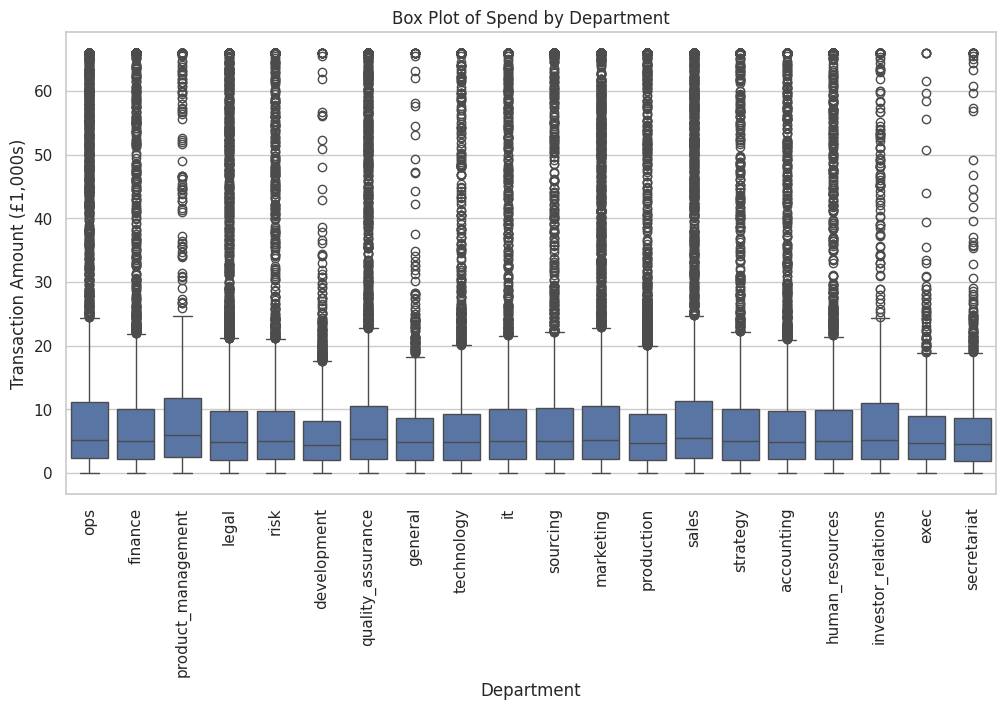

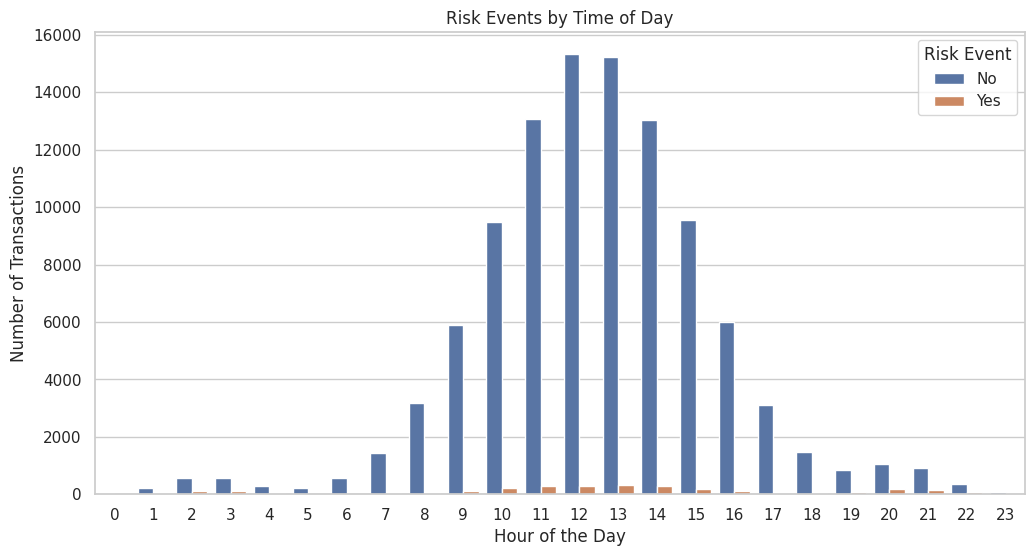

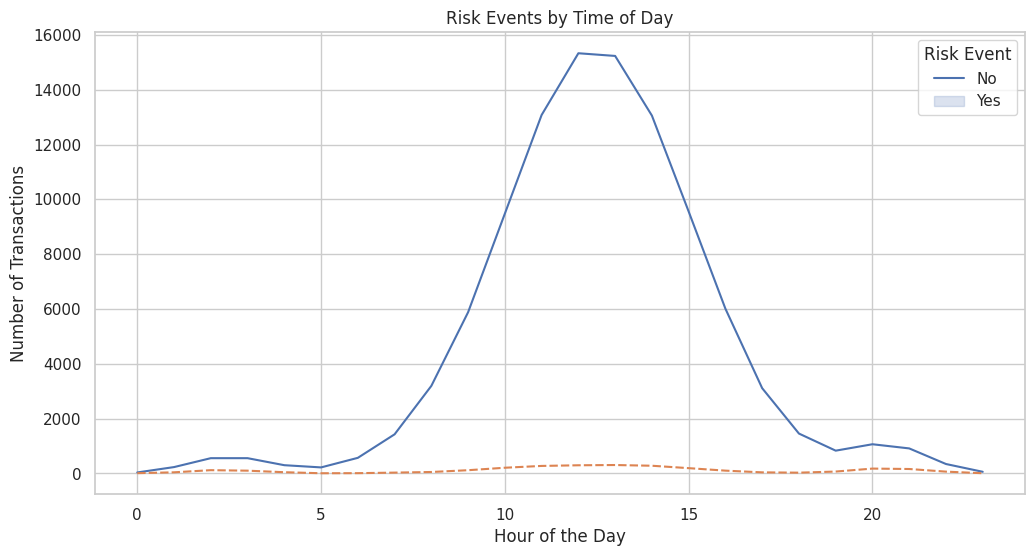

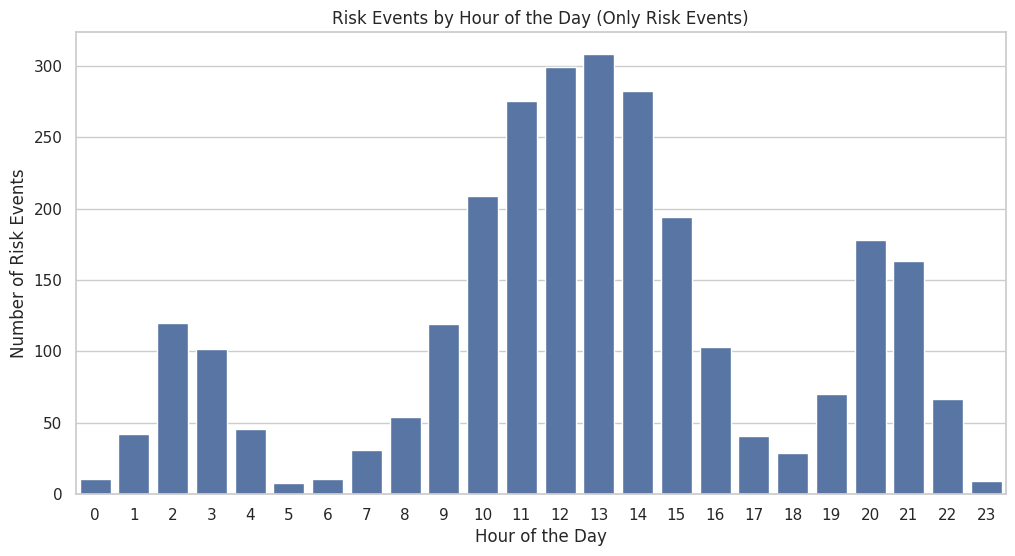

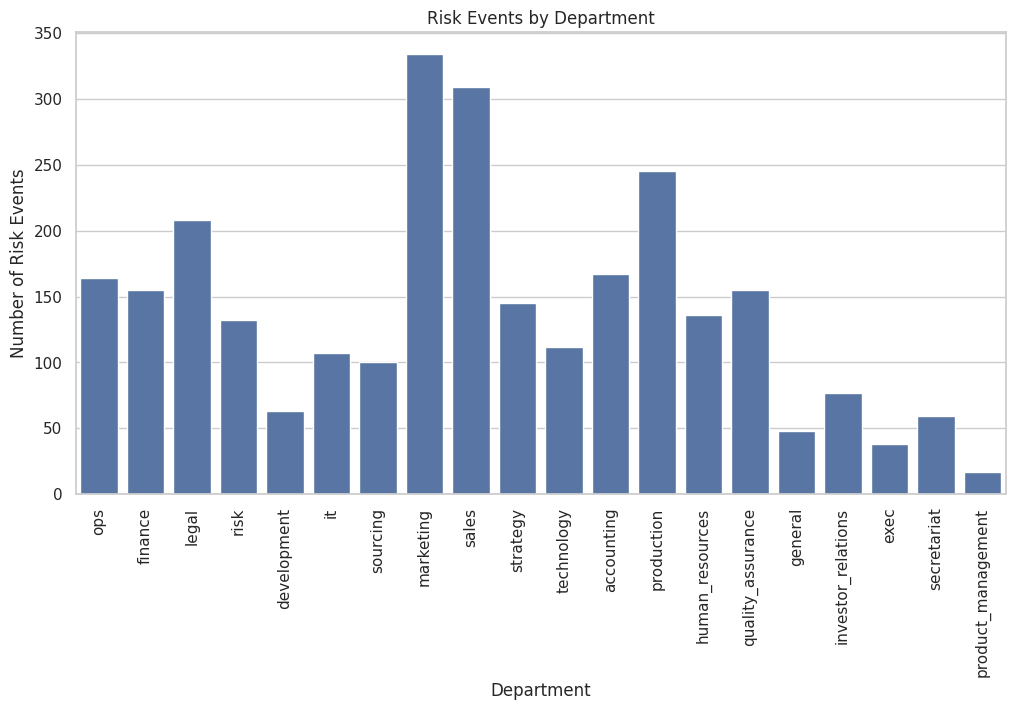

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot Figure: Histogram of Transaction Amounts
plt.figure(figsize=(12, 6))
sns.histplot(data['spend'], bins=50, kde=True)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount (£1,000s)')
plt.ylabel('Frequency')
plt.show()

# Plot Figure: Transactions by Hour of the Day
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=data)
plt.title('Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.show()

# Plot Figure: Box Plot of Spend by Department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='spend', data=data)
plt.title('Box Plot of Spend by Department')
plt.xlabel('Department')
plt.ylabel('Transaction Amount (£1,000s)')
plt.xticks(rotation=90)
plt.show()

# Plot Figure: Risk Events by Time of Day
df_test['hour'] = df_test['hour_of_day'].astype(int)
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', hue='at_risk_event', data=df_test)
plt.title('Risk Events by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.legend(title='Risk Event', loc='upper right', labels=['No', 'Yes'])
plt.show()

# Aggregate data by hour and risk event status
hourly_data = df_test.groupby(['hour', 'at_risk_event']).size().unstack().fillna(0)
hourly_data.columns = ['No', 'Yes']

# Plot Figure: Risk Events by Time of Day (Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_data)
plt.title('Risk Events by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.legend(title='Risk Event', loc='upper right', labels=['No', 'Yes'])
plt.show()

# Filter the data to include only risk events (at_risk_event == 1)
risk_event_data = df_test[df_test['at_risk_event'] == 1]

# Plot Figure: Risk Events by Hour of the Day (Bar Plot)
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=risk_event_data)
plt.title('Risk Events by Hour of the Day (Only Risk Events)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Risk Events')
plt.show()

# Plotting department-wise risk event count
plt.figure(figsize=(12, 6))
sns.countplot(x='department', data=risk_event_data)
plt.title('Risk Events by Department')
plt.xlabel('Department')
plt.ylabel('Number of Risk Events')
plt.xticks(rotation=90)
plt.show()


Model 1: At Risk Event

In [ ]:
# Function to evaluate model performance
def evaluate_model(model_name, y_true, y_pred):
    """
    Evaluate the model performance and print the classification report.
    
    Parameters:
    model_name (str): The name of the model.
    y_true (pd.Series): The true labels.
    y_pred (pd.Series): The predicted labels.
    """
    print(f"{model_name} Model Performance:")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"{model_name}:\n", classification_report(y_true, y_pred))

In [20]:
import numpy
from sklearn.ensemble import IsolationForest

# Encode categorical variable 'department' using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['department'], drop_first=True)
# Select relevant features for the model
features = ['day_of_week', 'is_weekend', 'is_office_hours',
            'rolling_spend_mean', 'rolling_spend_sum', 'time_diff', 'spend_to_mean_ratio',
            'spend_deviation', 'transactions_last_7_days', 'transactions_freq_deviation']
features.extend([col for col in data.columns if col.startswith('department_')])

# Isolation Forest
iso_forest = IsolationForest(max_samples=0.8, random_state=30, n_estimators=500, n_jobs=-1, max_features=1.0)
iso_forest.fit(data_encoded[features])

# Detect anomalies
data_encoded['anomaly_score'] = iso_forest.decision_function(data_encoded[features])
data_encoded['at_risk_event_if'] = iso_forest.predict(data_encoded[features])
data_encoded['at_risk_event_if'] = data_encoded['at_risk_event_if'].map({1: 0, -1: 1})

# Evaluate Isolation Forest
evaluate_model("Isolation Forest", y_true, data_encoded['at_risk_event_if'])

at_risk_event_if
0    99816
1     5461
Name: count, dtype: int64
Isolation Forest Model Performance:
F1 Score: 0.2757531584062196
Precision: 0.2078373924189709
Recall: 0.40959942259112236
Isolation Forest:
               precision    recall  f1-score   support

       False       0.98      0.96      0.97    102506
        True       0.21      0.41      0.28      2771

    accuracy                           0.94    105277
   macro avg       0.60      0.68      0.62    105277
weighted avg       0.96      0.94      0.95    105277



In [21]:

# Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

# Initialize and fit the Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.025)
data_encoded['anomaly_score_lof'] = lof.fit_predict(data_encoded[features])

# Convert scores to binary labels
data_encoded['at_risk_event_lof'] = data_encoded['anomaly_score_lof'].apply(lambda x: 1 if x == -1 else 0)
# Evaluate Local Outlier Factor
evaluate_model("Local Outlier Factor", y_true, data_encoded['at_risk_event_lof'])

Local Outlier Factor:
               precision    recall  f1-score   support

       False       0.98      0.98      0.98    102506
        True       0.13      0.13      0.13      2771

    accuracy                           0.96    105277
   macro avg       0.55      0.55      0.55    105277
weighted avg       0.95      0.96      0.95    105277

F1 Score: 0.12992781787895613
Precision: 0.13335866261398177
Recall: 0.12666907253699025


In [22]:
# DBSCAN
from sklearn.cluster import DBSCAN

# Initialize and fit the DBSCAN model
dbscan = DBSCAN(eps=0.2, min_samples=1000)
data_encoded['anomaly_score_dbscan'] = dbscan.fit_predict(data_encoded[features])

# Convert scores to binary labels (DBSCAN labels core points with cluster ids and noise points with -1)
data_encoded['at_risk_event_dbscan'] = data_encoded['anomaly_score_dbscan'].apply(lambda x: 1 if x == -1 else 0)
# Evaluate DBSCAN
evaluate_model("DBSCAN", y_true, data_encoded['at_risk_event_dbscan'])

DBSCAN:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00    102506
        True       0.03      1.00      0.05      2771

    accuracy                           0.03    105277
   macro avg       0.01      0.50      0.03    105277
weighted avg       0.00      0.03      0.00    105277

F1 Score: 0.05129201836220939
Precision: 0.026321038783399982
Recall: 1.0


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# Autoencoders
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
# Define the Autoencoder model
input_dim = data_encoded[features].shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(data_encoded[features], data_encoded[features], epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=1)

# Get reconstruction error
reconstructions = autoencoder.predict(data_encoded[features])
mse = np.mean(np.power(data_encoded[features] - reconstructions, 2), axis=1)
data_encoded['anomaly_score_ae'] = mse

# Set a threshold for anomaly detection (e.g., top 1% as anomalies)
threshold = np.percentile(mse, 99)
data_encoded['at_risk_event_ae'] = data_encoded['anomaly_score_ae'].apply(lambda x: 1 if x > threshold else 0)
# Evaluate Autoencoder
evaluate_model("Autoencoder", y_true, data_encoded['at_risk_event_ae'])

Epoch 1/50
2961/2961 [==============================] - 4s 1ms/step - loss: 209816.7500 - val_loss: 208207.2031
Epoch 2/50
2961/2961 [==============================] - 3s 1ms/step - loss: 207748.0000 - val_loss: 206145.9688
Epoch 3/50
2961/2961 [==============================] - 3s 1ms/step - loss: 205700.4219 - val_loss: 204103.6094
Epoch 4/50
2961/2961 [==============================] - 3s 966us/step - loss: 203672.2656 - val_loss: 202082.0000
Epoch 5/50
2961/2961 [==============================] - 3s 987us/step - loss: 201661.6719 - val_loss: 200076.3281
Epoch 6/50
2961/2961 [==============================] - 3s 1ms/step - loss: 199668.4062 - val_loss: 198088.3750
Epoch 7/50
2961/2961 [==============================] - 3s 1ms/step - loss: 197693.3906 - val_loss: 196119.0312
Epoch 8/50
2961/2961 [==============================] - 3s 973us/step - loss: 195731.7969 - val_loss: 194162.5938
Epoch 9/50
2961/2961 [==============================] - 3s 1ms/step - loss: 193786.7500 - val_loss

In [24]:
# One-Class SVM
from sklearn.svm import OneClassSVM

# Initialize and fit the One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.1)
data_encoded['anomaly_score_svm'] = oc_svm.fit_predict(data_encoded[features])

# Convert scores to binary labels
data_encoded['at_risk_event_svm'] = data_encoded['anomaly_score_svm'].apply(lambda x: 1 if x == -1 else 0)
# Evaluate One-Class SVM
evaluate_model("One-Class SVM", y_true, data_encoded['at_risk_event_svm'])

One-Class SVM:
               precision    recall  f1-score   support

       False       0.98      0.91      0.94    102506
        True       0.08      0.31      0.13      2771

    accuracy                           0.89    105277
   macro avg       0.53      0.61      0.54    105277
weighted avg       0.96      0.89      0.92    105277

F1 Score: 0.12945323633090827
Precision: 0.08170800984661995
Recall: 0.31143991338866833


Model 2: At Risk Behaviour Window

In [25]:
# More features for detecting behaviour window
# Moving average spend
data['moving_avg_spend_7d'] = data.groupby('individual_id')['spend'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
data['moving_avg_spend_14d'] = data.groupby('individual_id')['spend'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# Transaction frequency
data['trans_freq_7d'] = data.groupby('individual_id')['date'].transform(lambda x: x.rolling(window=7).count())
data['trans_freq_14d'] = data.groupby('individual_id')['date'].transform(lambda x: x.rolling(window=14).count())
data['trans_freq_30d'] = data.groupby('individual_id')['date'].transform(lambda x: x.rolling(window=30).count())

# Spend deviation
data['spend_deviation'] = data['spend'] - data['moving_avg_spend_7d']

In [26]:
import numpy
from sklearn.ensemble import IsolationForest

# Encode categorical variable 'department' using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['department'], drop_first=True)
# Select relevant features for the model
features = ['day_of_week', 'is_weekend', 'is_office_hours',
            'rolling_spend_mean', 'rolling_spend_sum', 'time_diff', 'spend_to_mean_ratio',
            'spend_deviation', 'transactions_last_7_days', 'transactions_freq_deviation',
            'moving_avg_spend_7d', 'moving_avg_spend_14d', 'trans_freq_7d', 'trans_freq_14d',
            'trans_freq_30d', 'spend_deviation']
features.extend([col for col in data.columns if col.startswith('department_')])

X = data_encoded[features]
X.fillna(0, inplace=True)


# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert numbers to True and NaN to False in a specified column
data_encoded['at_risk_behaviour_window'] = df_test['at_risk_behaviour_window'].apply(lambda x: True if pd.notna(x) else False)

/tmp/ipykernel_1437/3638287703.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [30]:
from sklearn.ensemble import IsolationForest

# Initialize and train Isolation Forest
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_scaled)

# Predict anomalies
data_encoded['anomaly_window_score_iso'] = iso_forest.decision_function(X_scaled)
data_encoded['anomaly_window_iso'] = iso_forest.predict(X_scaled)

# Map -1 to 1 (anomaly) and 1 to 0 (normal)
data_encoded['anomaly_window_iso'] = data_encoded['anomaly_window_iso'].map({1: 0, -1: 1})

# Verify predictions
print(data_encoded[['anomaly_window_score_iso', 'anomaly_window_iso']].head())
print(data_encoded['anomaly_window_iso'].value_counts())
evaluate_model("Isolation Forest", y_true, data_encoded['anomaly_window_iso'])

   anomaly_window_score_iso  anomaly_window_iso
0                 -0.042471                   1
1                 -0.044373                   1
2                 -0.009167                   1
3                  0.026755                   0
4                  0.025768                   0
anomaly_window_iso
0    85255
1    20022
Name: count, dtype: int64
Isolation Forest Model Performance:
F1 Score: 0.1765454306146624
Precision: 0.10048946159224853
Recall: 0.7260916636593288
Isolation Forest:
               precision    recall  f1-score   support

       False       0.99      0.82      0.90    102506
        True       0.10      0.73      0.18      2771

    accuracy                           0.82    105277
   macro avg       0.55      0.78      0.54    105277
weighted avg       0.97      0.82      0.88    105277



In [31]:
from sklearn.cluster import DBSCAN

# Initialize and fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=100)
data_encoded['anomaly_window_dbscan_labels'] = dbscan.fit_predict(X_scaled)

# Identify anomalies (points labeled as -1 by DBSCAN)
data_encoded['anomaly_window_dbscan'] = (data_encoded['anomaly_window_dbscan_labels'] == -1).astype(int)

# Verify the clustering and anomaly detection
print(data_encoded[['anomaly_window_dbscan_labels', 'anomaly_window_dbscan']].head())
print(data_encoded['anomaly_window_dbscan'].value_counts())
evaluate_model("DBSCAN", y_true, data_encoded['anomaly_window_dbscan'])

   anomaly_window_dbscan_labels  anomaly_window_dbscan
0                             0                      0
1                            -1                      1
2                            -1                      1
3                            -1                      1
4                            -1                      1
anomaly_window_dbscan
1    57802
0    47475
Name: count, dtype: int64
DBSCAN Model Performance:
F1 Score: 0.09149290938206792
Precision: 0.04793951766374866
Recall: 1.0
DBSCAN:
               precision    recall  f1-score   support

       False       1.00      0.46      0.63    102506
        True       0.05      1.00      0.09      2771

    accuracy                           0.48    105277
   macro avg       0.52      0.73      0.36    105277
weighted avg       0.97      0.48      0.62    105277

